In [196]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [197]:
data = pd.read_csv("data/googleplaystore.csv",encoding='utf-8')

In [198]:
"""
Number of Free Apps vs Paid Apps
"""
free_apps = len(data[data["Type"] == "Free"])
print("Free Apps: ", free_apps)
paid_apps = len(data[data["Type"] == "Paid"])
print("Paid Apps: ", paid_apps)

Free Apps:  10039
Paid Apps:  800


In [199]:
"""
App with most Reviews
"""
data['Reviews'] = pd.to_numeric(data['Reviews'],errors='coerce')
most_reviews = data.sort_values('Reviews',ascending=False).iloc[0]['App']
print("App with most Reviews: ", most_reviews)

"""
App with least Reviews
"""
data['Reviews'] = pd.to_numeric(data['Reviews'],errors='coerce')
least_reviews = data.sort_values('Reviews').iloc[0]['App']
print("App with the least Reviews: ", least_reviews)

App with most Reviews:  Facebook
App with the least Reviews:  BAR-B-Q Recipes


In [200]:

d = pd.to_numeric(data["Reviews"], errors="coerce")
print(data["Reviews"].head())
print(d.head())

0       159.0
1       967.0
2     87510.0
3    215644.0
4       967.0
Name: Reviews, dtype: float64
0       159.0
1       967.0
2     87510.0
3    215644.0
4       967.0
Name: Reviews, dtype: float64


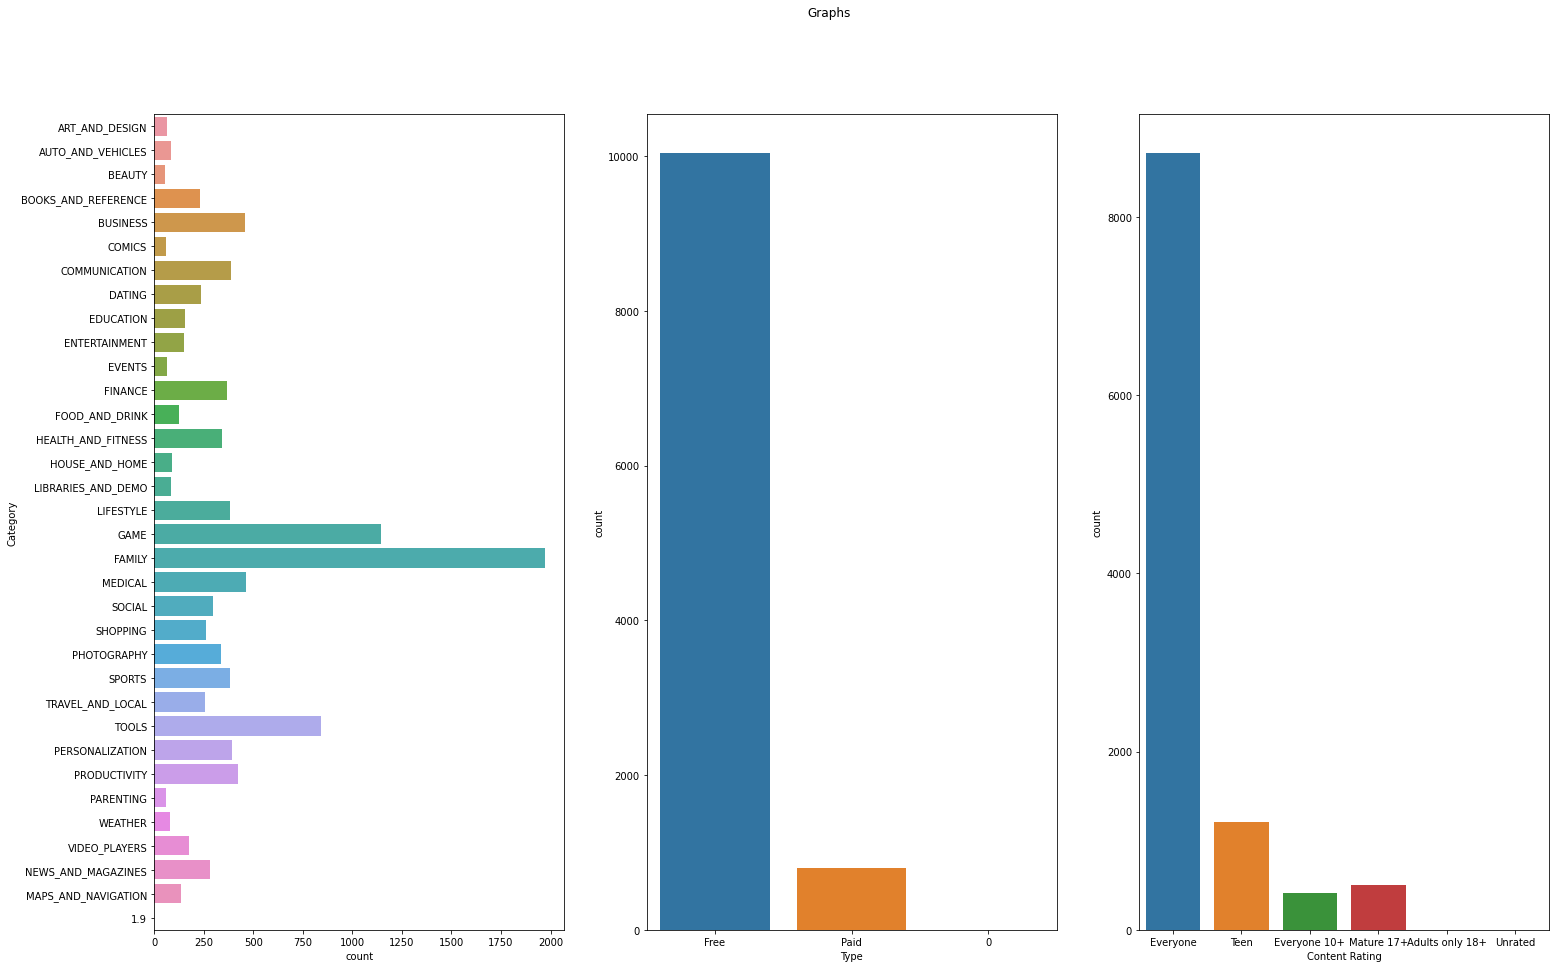

In [201]:
"""
Graphs to display:
    - number of apps in each category
    - number of paid and free apps
    - distribution of number of apps based on their Content Rating
"""

fig,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 15))
plt.suptitle('Graphs')
sns.countplot(y='Category', data=data,ax=ax1)
sns.countplot(x='Type', data=data,ax=ax2)
sns.countplot(x='Content Rating', data=data,ax=ax3)
plt.show()

In [202]:
def plot_target_by_group(df, target_col, group_col, figsize=(6,4), title=""):
    """
    Plot the mean of a target column (Numeric) groupped by the group column (categorical)
    """
    order = sorted(list(set(df[group_col])))
    stats = df.groupby(group_col).mean()[target_col]
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x=group_col, y=target_col, data=df, ax=ax, order=order).set_title(title)
    ax.set(ylim=(3.8, 4.5))  
    ax.tick_params(labelrotation=90)
    return stats

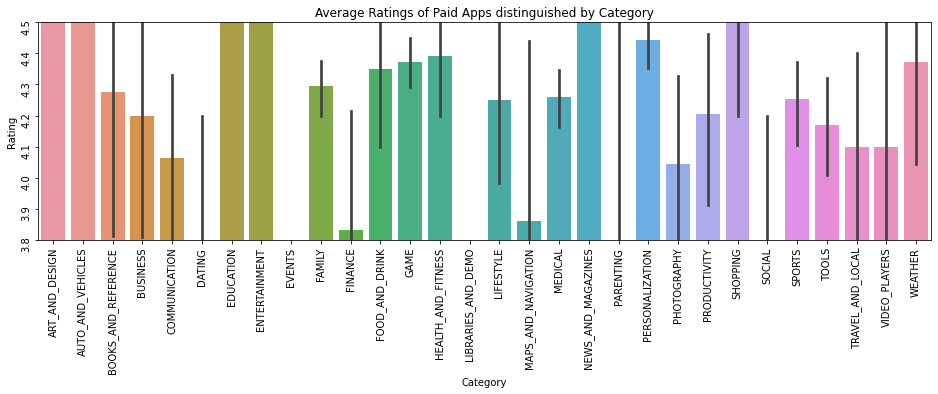

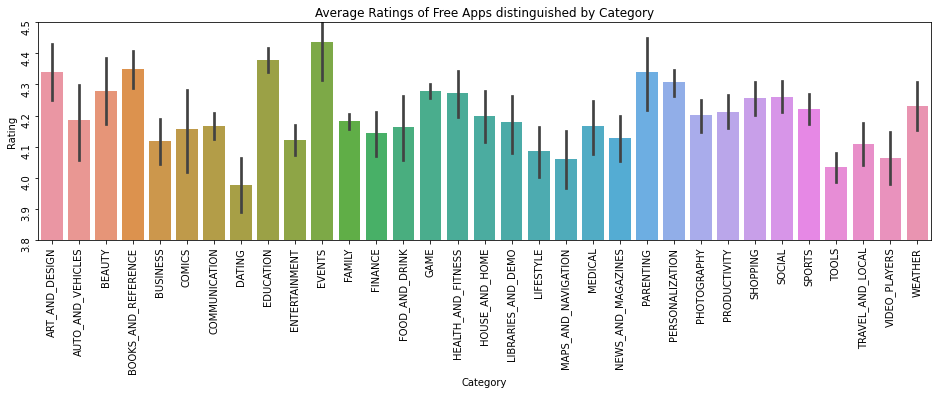

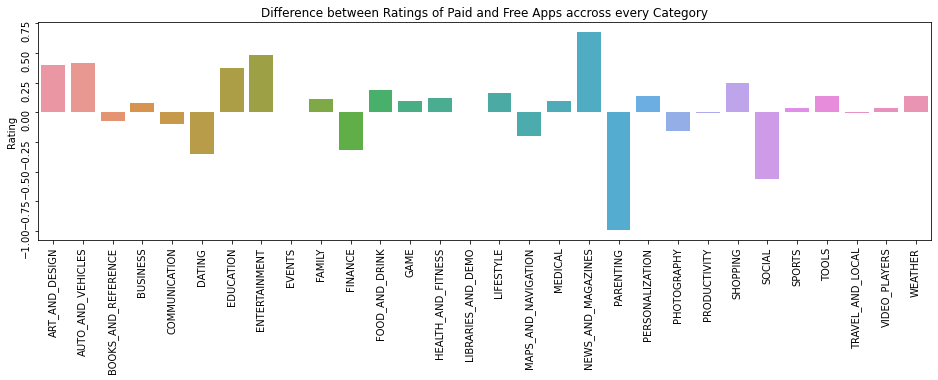

In [203]:
"""
Rating Distribution based on Free and Paid Apps
"""
new_data = data[['Rating', 'Type', 'Category']]
paid_stats = plot_target_by_group(new_data.query('Type == "Paid"'), 'Rating', 'Category', (16, 4), "Average Ratings of Paid Apps distinguished by Category")
free_stats = plot_target_by_group(new_data.query('Type == "Free"'), 'Rating', 'Category', (16, 4), "Average Ratings of Free Apps distinguished by Category")

fig, ax = plt.subplots(figsize=(16,4))
sorted_idx = sorted(paid_stats.index)
rating_diff = paid_stats[sorted_idx] - free_stats[sorted_idx]
graph = sns.barplot(x=sorted_idx, y=rating_diff, ax=ax)
graph.set_title("Difference between Ratings of Paid and Free Apps accross every Category");
graph.tick_params(labelrotation=90)

In [204]:
data.drop([10472],inplace=True)
data[10470:10475]


threshold= len(data)*0.1
threshold

data.dropna(thresh=threshold,axis=1,inplace=True)
print(data.isnull().sum())

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64


In [205]:
def impute_median(series):
    return series.fillna(series.median())
data["Rating"]= data["Rating"].transform(impute_median)
data.isnull().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              1
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       8
Android Ver       2
dtype: int64

In [206]:
# Now imputing the categorical values
data["Type"].fillna(str(data["Type"].mode().values[0]),inplace=True)
data["Current Ver"].fillna(str(data["Current Ver"].mode().values[0]), inplace=True)
data["Android Ver"].fillna(str(data["Android Ver"].mode().values[0]),inplace=True)

In [207]:
data["Price"]= data["Price"].apply(lambda x:str(x).replace("$","") if "$" in str(x) else str(x))
data["Price"]= data["Price"].apply(lambda x: float(x))

data["Reviews"]= pd.to_numeric(data["Reviews"], errors="coerce")

data["Installs"]= data["Installs"].apply(lambda x: str(x).replace("+","") if "+" in str(x) else str(x))
data["Installs"]= data["Installs"].apply(lambda x: str(x).replace(",","") if "," in str(x) else str(x))
data["Installs"]=data["Installs"].apply(lambda x: float(x))

In [208]:
data["Rating"]= pd.to_numeric(data["Rating"],errors="coerce")

In [209]:
pred_data = data.copy()

In [210]:
cols = [('Category', 'Cat'), ('Content Rating', 'CR'), ('Type', 'Ty')]
dummy_cols = [pd.get_dummies(data[c[0]], prefix=c[1], drop_first=True) for c in cols]

pred_data = pd.concat([pred_data, *dummy_cols], axis=1)
pred_data.drop([c[0] for c in cols], axis=1, inplace=True)

In [211]:
pred_data.drop(['Current Ver', 'Android Ver', 'App', 'Last Updated', 'Size', 'Genres'], axis=1, inplace=True)

In [212]:
xn = pred_data.drop(['Rating'],axis=1)
yn = pred_data['Rating'].values
X_train, X_test, y_train, y_test = train_test_split(xn, yn, test_size = 0.2, random_state=0)

In [213]:
X_scaled = StandardScaler()
X_train = X_scaled.fit_transform(X_train)
X_test=X_scaled.transform(X_test)

In [214]:
rand_forest = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rand_forest.fit(X_train, y_train)
rand_forest_predict = rand_forest.predict(X_test)

No handles with labels found to put in legend.


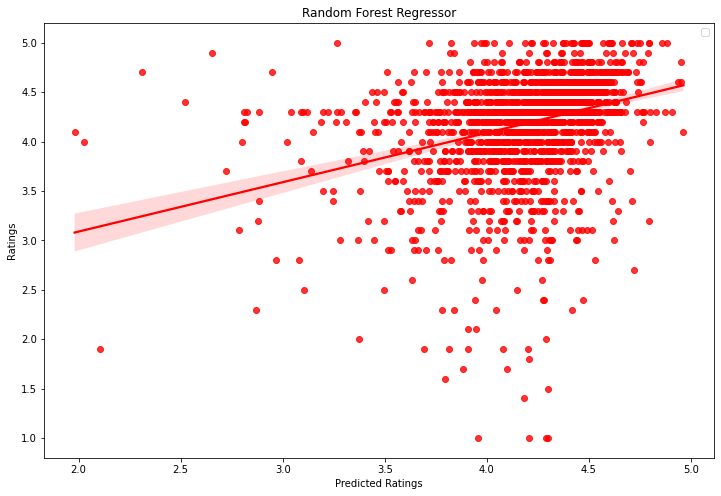

In [215]:
plt.figure(figsize=(12,8))
sns.regplot(x=rand_forest_predict, y=y_test, color='red')
plt.legend()
plt.title("Random Forest Regressor")
plt.xlabel('Predicted Ratings')
plt.ylabel('Ratings')
plt.show()

In [216]:
print( f'Mean Squared Error: { round(metrics.mean_squared_error(y_test,rand_forest_predict), 2)} degrees.' )
print( f'Mean Absolute Error: { round(metrics.mean_absolute_error(y_test, rand_forest_predict), 2)} degrees.' )
print( f"Root Mean Squared Error: { round(np.sqrt(mean_squared_error(y_test, rand_forest_predict)), 2) } degrees." )

Mean Squared Error: 0.24 degrees.
Mean Absolute Error: 0.3 degrees.
Root Mean Squared Error: 0.49 degrees.


In [217]:
errors = abs(rand_forest_predict - y_test)
errors_percent = 100*(errors/y_test)
accuracy = 100 - np.mean(errors_percent)
print(f"Accuracy: {round(accuracy, 2)} %")

Accuracy: 91.3 %
